# UAP MACHINE LEARNING
## Nama : Zulkifli A. Patuti
## Nim : 202210370311180
## UAP MACHINE LEARNING

# 1.Data Prepration

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import joblib
import torch

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

!pip install pytorch-tabnet

# 2.Load Data

In [ ]:
file_path = "covid_19_indonesia_time_series_all.csv"

df = pd.read_csv(file_path)

df = df[df['Location Level'] == 'Province'].copy()

print(f"Total baris:{df.shape[0]}")
print(f"Total kolom: {df.shape[1]}")

Total baris:30893
Total kolom: 38


# 3.Preprocessing

##Cleaning Data

In [ ]:
cols_percent = ['Case Fatality Rate', 'Case Recovered Rate']
for col in cols_percent:
    df[col] = df[col].astype(str).str.rstrip('%').astype('float')

df['Growth Factor of New Cases'] = df['Growth Factor of New Cases'].fillna(1.0)
df['Growth Factor of New Deaths'] = df['Growth Factor of New Deaths'].fillna(1.0)

cols_fill_zero = ['Total Cities', 'Total Urban Villages', 'Total Rural Villages']
df[cols_fill_zero] = df[cols_fill_zero].fillna(0)

print("Pembersihan data dasar selesai.")
print("Sisa Missing Value:", df.isnull().sum().sum())

Pembersihan data dasar selesai.
Sisa Missing Value: 57228


##Feature Engineering

In [ ]:
q1 = df['New Cases per Million'].quantile(0.33)
q2 = df['New Cases per Million'].quantile(0.66)

def categorize_risk(val):
    if val <= q1:
        return 0
    elif val <= q2:
        return 1
    else:
        return 2

df['Risk_Level'] = df['New Cases per Million'].apply(categorize_risk)
print("Distribusi Kelas:")
print(df['Risk_Level'].value_counts())

Distribusi Kelas:
Risk_Level
2    10502
0    10203
1    10188
Name: count, dtype: int64


##Explaritory Data Analysis

/tmp/ipython-input-111055079.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Risk_Level', data=df, palette='viridis')


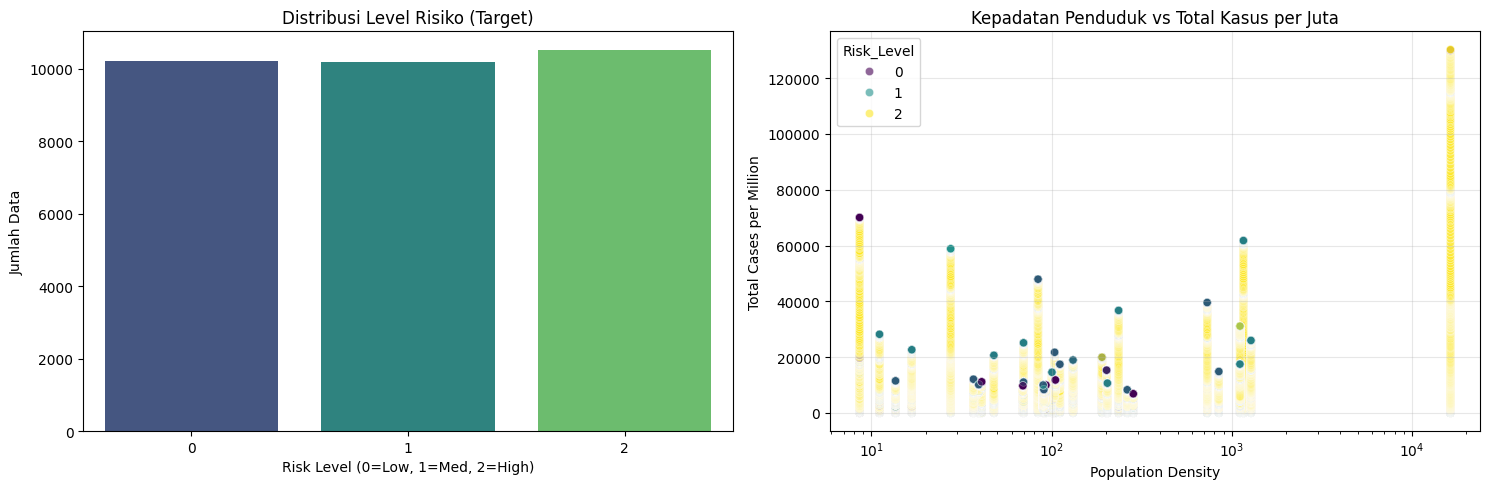

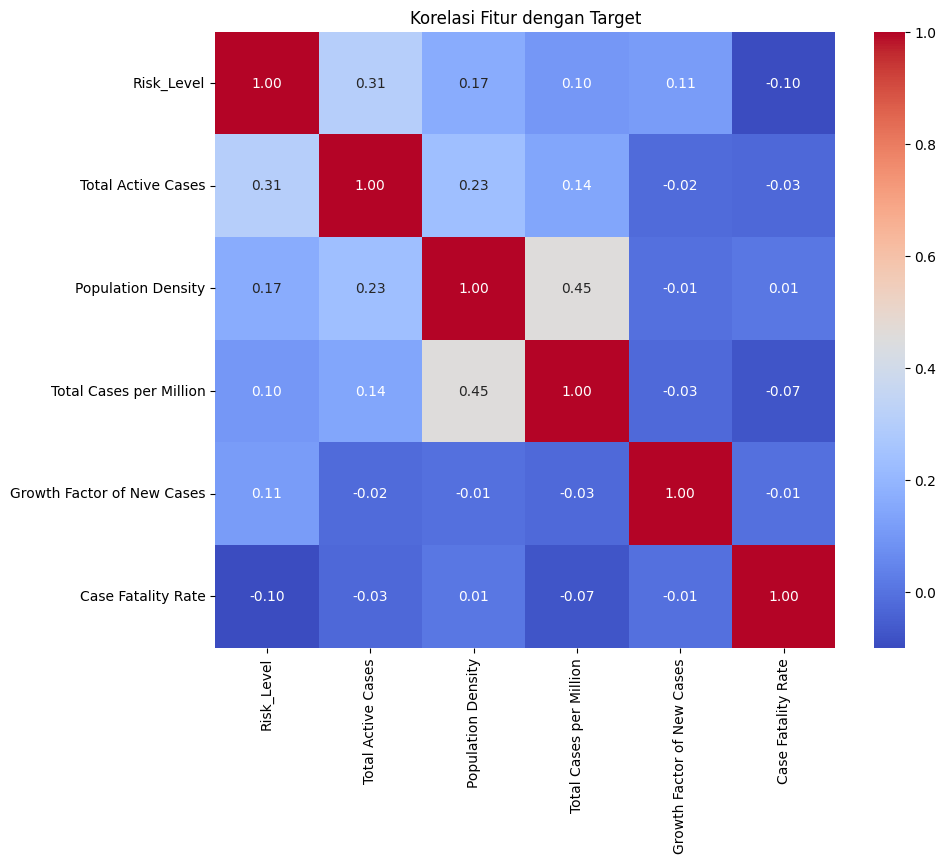

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='Risk_Level', data=df, palette='viridis')
plt.title('Distribusi Level Risiko (Target)')
plt.xlabel('Risk Level (0=Low, 1=Med, 2=High)')
plt.ylabel('Jumlah Data')

plt.subplot(1, 2, 2)
sns.scatterplot(x='Population Density', y='Total Cases per Million', hue='Risk_Level', data=df, palette='viridis', alpha=0.6)
plt.title('Kepadatan Penduduk vs Total Kasus per Juta')
plt.xscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
cols_corr = ['Risk_Level', 'Total Active Cases', 'Population Density',
             'Total Cases per Million', 'Growth Factor of New Cases',
             'Case Fatality Rate']
sns.heatmap(df[cols_corr].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korelasi Fitur dengan Target')
plt.show()

# 4.Feature Selection

In [ ]:
selected_features = [
    'Total Active Cases',
    'Total Cases per Million',
    'Total Deaths per Million',
    'Population Density',
    'Growth Factor of New Cases',
    'Case Fatality Rate',
    'Case Recovered Rate',
    'Total Cities',
    'Total Regencies',
    'Longitude',
    'Latitude'
]

X = df[selected_features]
y = df['Risk_Level']

In [ ]:
print(f"Fitur X({len(selected_features)} kolom):")
print(selected_features)

Fitur X(11 kolom):
['Total Active Cases', 'Total Cases per Million', 'Total Deaths per Million', 'Population Density', 'Growth Factor of New Cases', 'Case Fatality Rate', 'Case Recovered Rate', 'Total Cities', 'Total Regencies', 'Longitude', 'Latitude']


# 5.Data Splitting & Scalling

In [ ]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.176, random_state=42, stratify=y_train_full)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
df_test_export = pd.DataFrame(X_test, columns=selected_features)
df_test_export['Actual_Risk'] = y_test

print(f"Shape Train: {X_train_scaled.shape}")
print(f"Shape Val  : {X_val_scaled.shape}")
print(f"Shape Test : {X_test_scaled.shape}")

Shape Train: (21637, 11)
Shape Val  : (4622, 11)
Shape Test : (4634, 11)


In [ ]:
joblib.dump(scaler, 'scaler_covid.pkl')
df_test_export.to_csv('data_test_streamlit.csv', index=False)

# 6 Implementasi Model

In [ ]:
input_dim = X_train_scaled.shape[1]
num_classes = 3

print(f"Input Features: {input_dim}")
print(f"Output Classes: {num_classes}")

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Input Features: 11
Output Classes: 3


## Skenario 1 = Model Multilayer Perceptron

In [ ]:
model_mlp = Sequential([
    Dense(64, activation='relu', input_shape=(input_dim,)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_mlp = model_mlp.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50, batch_size=32, callbacks=[early_stop], verbose=1
)

model_mlp.save('model_1.h5')

Epoch 1/50
677/677 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5597 - loss: 0.8993 - val_accuracy: 0.7226 - val_loss: 0.6229
Epoch 2/50
677/677 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7437 - loss: 0.5841 - val_accuracy: 0.7408 - val_loss: 0.5645
Epoch 3/50
677/677 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7676 - loss: 0.5337 - val_accuracy: 0.7581 - val_loss: 0.5536
Epoch 4/50
677/677 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7746 - loss: 0.5166 - val_accuracy: 0.7772 - val_loss: 0.5272
Epoch 5/50
677/677 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7786 - loss: 0.5145 - val_accuracy: 0.7711 - val_loss: 0.5321
Epoch 6/50
677/677 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7946 - loss: 0.4888 - val_accuracy: 0.7739 - val_loss: 0.5176
Epoch 7/50
677/677 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7921 - loss: 0.4800 - val_accuracy: 0.7726 - val_loss: 0.5288
Epoch 8/50
677/677 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7957 - loss: 0.4756 - val_accuracy:

## Skenario 2 = Model Autoencoder + Fine Tuning

In [ ]:
input_layer = Input(shape=(input_dim,))

encoded = Dense(32, activation='relu')(input_layer)
encoded = BatchNormalization()(encoded)
encoded = Dense(16, activation='relu', name='bottleneck')(encoded)

decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(X_train_scaled, X_train_scaled, epochs=20, batch_size=32,
                validation_data=(X_val_scaled, X_val_scaled), verbose=0)

encoder_only = Model(input_layer, encoded)
encoder_only.trainable = True

x = encoder_only(input_layer)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(num_classes, activation='softmax')(x)

model_ae = Model(inputs=input_layer, outputs=output)
model_ae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

history_ae = model_ae.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)
model_ae.save('model_2.h5')

Epoch 1/100
677/677 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3475 - loss: 1.1928 - val_accuracy: 0.4288 - val_loss: 1.0573
Epoch 2/100
677/677 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4257 - loss: 1.0642 - val_accuracy: 0.5699 - val_loss: 0.9645
Epoch 3/100
677/677 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5197 - loss: 0.9701 - val_accuracy: 0.6287 - val_loss: 0.8692
Epoch 4/100
677/677 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5720 - loss: 0.8897 - val_accuracy: 0.6564 - val_loss: 0.8007
Epoch 5/100
677/677 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6079 - loss: 0.8302 - val_accuracy: 0.6644 - val_loss: 0.7608
Epoch 6/100
677/677 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6334 - loss: 0.7934 - val_accuracy: 0.6781 - val_loss: 0.7278
Epoch 7/100
677/677 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6424 - loss: 0.7734 - val_accuracy: 0.6841 - val_loss: 0.7069
Epoch 8/100
677/677 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6563 - loss: 0.7543 - val_accu

## Skenario 3 = Model Tabnet + Fine Tuning

In [ ]:
unsupervised_model = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax'
)

unsupervised_model.fit(
    X_train=X_train_scaled,
    eval_set=[X_val_scaled],
    max_epochs=15, patience=5,
    batch_size=256, virtual_batch_size=128,
    num_workers=0, drop_last=False,
    pretraining_ratio=0.8
)

model_tabnet = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
)

model_tabnet.fit(
    X_train=X_train_scaled, y_train=y_train,
    eval_set=[(X_train_scaled, y_train), (X_val_scaled, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'],
    max_epochs=100, patience=10,
    batch_size=256, virtual_batch_size=128,
    num_workers=0, drop_last=False,
    from_unsupervised=unsupervised_model
)

model_tabnet.save_model("model_3")

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.52529 | val_0_unsup_loss_numpy: 0.8800299763679504|  0:00:02s
epoch 1  | loss: 0.9424  | val_0_unsup_loss_numpy: 0.8068299889564514|  0:00:06s
epoch 2  | loss: 0.90961 | val_0_unsup_loss_numpy: 0.784060001373291|  0:00:12s
epoch 3  | loss: 0.91758 | val_0_unsup_loss_numpy: 0.7521299719810486|  0:00:17s
epoch 4  | loss: 0.90406 | val_0_unsup_loss_numpy: 0.7208799719810486|  0:00:20s
epoch 5  | loss: 0.90247 | val_0_unsup_loss_numpy: 0.6737499833106995|  0:00:23s
epoch 6  | loss: 0.8896  | val_0_unsup_loss_numpy: 0.6985700130462646|  0:00:25s
epoch 7  | loss: 0.8856  | val_0_unsup_loss_numpy: 0.6890000104904175|  0:00:28s
epoch 8  | loss: 0.88368 | val_0_unsup_loss_numpy: 0.6842399835586548|  0:00:30s
epoch 9  | loss: 0.86871 | val_0_unsup_loss_numpy: 0.7037100195884705|  0:00:33s
epoch 10 | loss: 0.87373 | val_0_unsup_loss_numpy: 0.6394199728965759|  0:00:36s
epoch 11 | loss: 0.87289 | val_0_unsup_loss_numpy: 0.667739987373352|  0:00:41s
epoch 12 | loss: 0.85543 | val

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:118: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:248: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 1.92094 | train_accuracy: 0.35046 | valid_accuracy: 0.34833 |  0:00:05s
epoch 1  | loss: 1.09512 | train_accuracy: 0.46827 | valid_accuracy: 0.47166 |  0:00:13s
epoch 2  | loss: 0.96966 | train_accuracy: 0.51814 | valid_accuracy: 0.5199  |  0:00:19s
epoch 3  | loss: 0.91401 | train_accuracy: 0.54753 | valid_accuracy: 0.54003 |  0:00:25s
epoch 4  | loss: 0.87884 | train_accuracy: 0.57383 | valid_accuracy: 0.56729 |  0:00:31s
epoch 5  | loss: 0.84524 | train_accuracy: 0.60424 | valid_accuracy: 0.60385 |  0:00:40s
epoch 6  | loss: 0.81094 | train_accuracy: 0.6298  | valid_accuracy: 0.619   |  0:00:46s
epoch 7  | loss: 0.78107 | train_accuracy: 0.6256  | valid_accuracy: 0.61878 |  0:00:55s
epoch 8  | loss: 0.75313 | train_accuracy: 0.64334 | valid_accuracy: 0.63371 |  0:01:02s
epoch 9  | loss: 0.73401 | train_accuracy: 0.6537  | valid_accuracy: 0.64215 |  0:01:09s
epoch 10 | loss: 0.71908 | train_accuracy: 0.64986 | valid_accuracy: 0.64756 |  0:01:12s
epoch 11 | loss: 0.69

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Successfully saved model at model_3.zip


'model_3.zip'

# 7. Evaluasi Metric

In [ ]:
y_prob_mlp = model_mlp.predict(X_test_scaled)
y_pred_mlp = np.argmax(y_prob_mlp, axis=1)

y_prob_ae = model_ae.predict(X_test_scaled)
y_pred_ae = np.argmax(y_prob_ae, axis=1)

y_pred_tabnet = model_tabnet.predict(X_test_scaled)

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


## Accuracy

In [ ]:
target_names = ['Low Risk', 'Medium Risk', 'High Risk']

print("\n" + "="*40)
print("  EVALUASI MODEL 1: MLP (Non-Pretrained)")
print("="*40)
print(classification_report(y_test, y_pred_mlp, target_names=target_names))

print("\n" + "="*40)
print("  EVALUASI MODEL 2: AutoEncoder (Pretrained)")
print("="*40)
print(classification_report(y_test, y_pred_ae, target_names=target_names))

print("\n" + "="*40)
print("  EVALUASI MODEL 3: TabNet (Transfer Learning)")
print("="*40)
print(classification_report(y_test, y_pred_tabnet, target_names=target_names))


  EVALUASI MODEL 1: MLP (Non-Pretrained)
              precision    recall  f1-score   support

    Low Risk       0.85      0.89      0.87      1531
 Medium Risk       0.76      0.71      0.73      1528
   High Risk       0.86      0.88      0.87      1575

    accuracy                           0.82      4634
   macro avg       0.82      0.82      0.82      4634
weighted avg       0.82      0.82      0.82      4634


  EVALUASI MODEL 2: AutoEncoder (Pretrained)
              precision    recall  f1-score   support

    Low Risk       0.84      0.87      0.85      1531
 Medium Risk       0.72      0.69      0.70      1528
   High Risk       0.85      0.86      0.85      1575

    accuracy                           0.81      4634
   macro avg       0.80      0.81      0.80      4634
weighted avg       0.80      0.81      0.80      4634


  EVALUASI MODEL 3: TabNet (Transfer Learning)
              precision    recall  f1-score   support

    Low Risk       0.86      0.57      0.68    

## Confusion Matirx

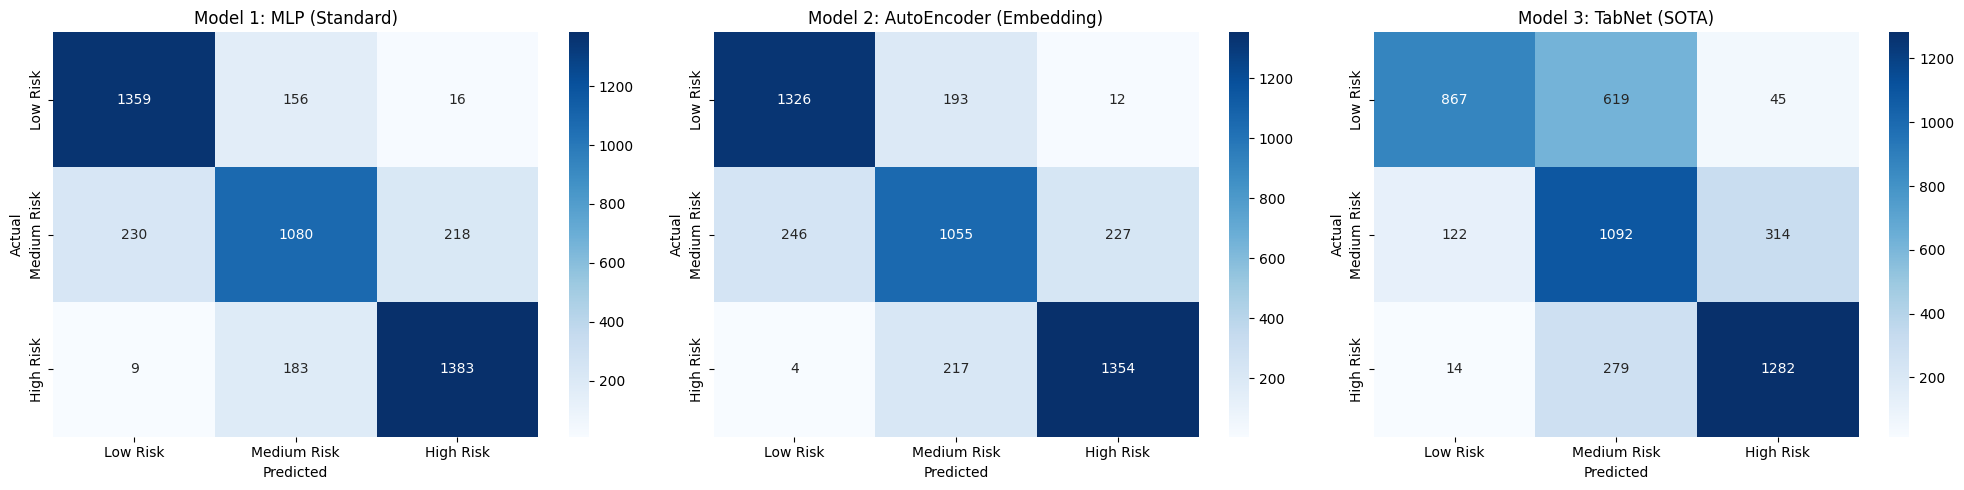

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

def plot_cm(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels(target_names)
    ax.set_yticklabels(target_names)

plot_cm(y_test, y_pred_mlp, "Model 1: MLP (Standard)", axes[0])
plot_cm(y_test, y_pred_ae, "Model 2: AutoEncoder (Embedding)", axes[1])
plot_cm(y_test, y_pred_tabnet, "Model 3: TabNet (SOTA)", axes[2])

plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

## Loss & Accuracy Validation

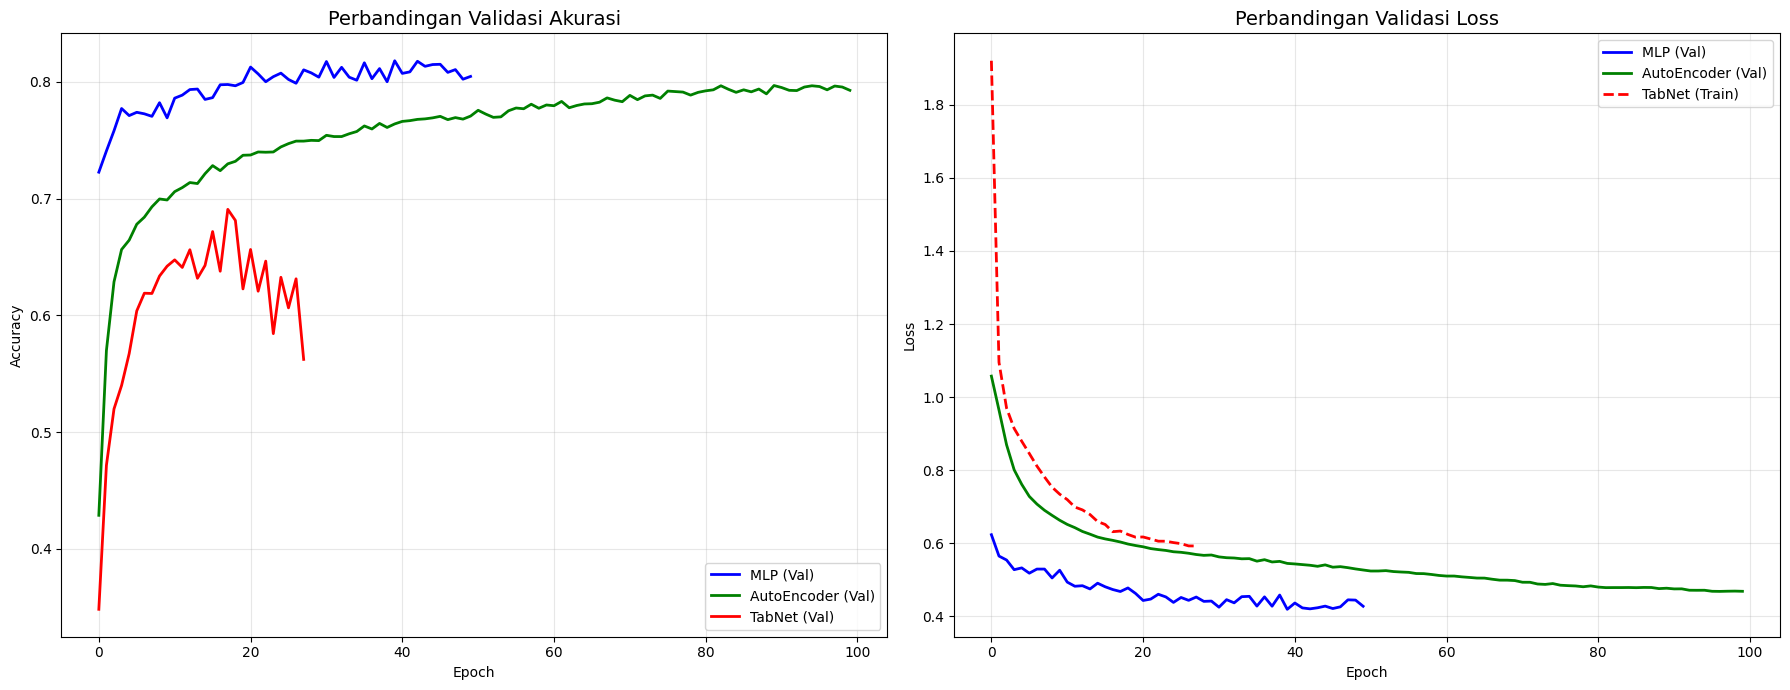

In [ ]:
plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)
plt.plot(history_mlp.history['val_accuracy'], label='MLP (Val)', color='blue', linewidth=2)
plt.plot(history_ae.history['val_accuracy'], label='AutoEncoder (Val)', color='green', linewidth=2)
plt.plot(model_tabnet.history['valid_accuracy'], label='TabNet (Val)', color='red', linewidth=2)

plt.title('Perbandingan Validasi Akurasi', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_mlp.history['val_loss'], label='MLP (Val)', color='blue', linewidth=2)
plt.plot(history_ae.history['val_loss'], label='AutoEncoder (Val)', color='green', linewidth=2)
try:
    plt.plot(model_tabnet.history['valid_loss'], label='TabNet (Val)', color='red', linewidth=2)
except:
    plt.plot(model_tabnet.history['loss'], label='TabNet (Train)', color='red', linestyle='--', linewidth=2)

plt.title('Perbandingan Validasi Loss', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('grafik_loss_accuracy.png')
plt.show()